In [1]:
#imports
import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append('/home/elenaruiz/Documents/FNC')
import pandas as pd
import numpy as np
from src.utils import io
from src.fake_news_detector.core.classificators import LDA, QDA, helpers
import matplotlib.pyplot as plt

## Import dataset

In [2]:
articles = io.read_json_file('/home/elenaruiz/Documents/FNC/src/data/dataset_style.json')
df = pd.DataFrame(data=articles['articles'])

## Variables to classify

In [3]:
column_names = ['pert_different_words', 'title_sentiment', 'pert_total_nouns', 'n_words', 'pert_total_verbs', 'mean_words_per_sentence' ]
df[column_names].head()

,pert_different_words,title_sentiment,pert_total_nouns,n_words,pert_total_verbs,mean_words_per_sentence
0,0.696296,-0.5719,0.607407,135,0.170370,6.096296
1,0.622951,-0.1027,0.612022,183,0.114754,6.688525
2,0.818966,-0.4588,0.594828,116,0.120690,5.896552
3,0.772727,-0.2023,0.439394,66,0.181818,5.363636
4,0.818182,-0.4767,0.636364,66,0.121212,6.454545


## Standarize

In [4]:
from sklearn.preprocessing import StandardScaler
x = df[column_names]

scaler = StandardScaler()
scaled_df = scaler.fit_transform(x)

dataset_std = pd.DataFrame(scaled_df, columns=column_names)

# Add factor label
dataset_std['fake'] = df['fake']
dataset_std.head()

,pert_different_words,title_sentiment,pert_total_nouns,n_words,pert_total_verbs,mean_words_per_sentence,fake
0,-0.676123,-1.303625,-0.061732,-0.560411,1.520931,-0.357702,True
1,-1.700977,0.180281,0.008543,-0.185189,-0.265574,1.029531,True
2,1.037931,-0.945932,-0.253314,-0.708936,-0.074912,-0.825582,True
3,0.391845,-0.134717,-2.620462,-1.099791,1.888657,-2.073881,True
4,1.026980,-1.002543,0.379252,-1.099791,-0.058130,0.481459,True


## Split datasets

In [5]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(dataset_std, test_size=0.2, random_state=42)
# V A L U E S
X_std_train = df_train[column_names].values
Y_train = df_train.fake

X_std_test = df_test[column_names].values
Y_test = df_test.fake

## Direct Classification with SVM

In [6]:
from src.fake_news_detector.core.classificators import SupportVectorMachine as s
from sklearn import svm
from sklearn.model_selection import GridSearchCV

In [7]:
def svc_param_selection(X, y, nfolds, kernel):
    Cs = [0.001, 0.01, 0.1, 1, 10]
    gammas = [0.001, 0.01, 0.1, 1]
    param_grid = {'C': Cs, 'gamma' : gammas}
    grid_search = GridSearchCV(svm.SVC(kernel=kernel), param_grid, cv=nfolds)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_

In [8]:
print('For rbf:', svc_param_selection(X_std_train, Y_train, 2, 'rbf'))
print('For linear:', svc_param_selection(X_std_train, Y_train, 2, 'linear'))
print('For poly:', svc_param_selection(X_std_train, Y_train, 2, 'poly'))
print('For sigmoid:', svc_param_selection(X_std_train, Y_train, 2, 'sigmoid'))

For rbf: {'C': 10, 'gamma': 1}
For linear: {'C': 1, 'gamma': 0.001}
For poly: {'C': 0.1, 'gamma': 1}
For sigmoid: {'C': 1, 'gamma': 0.1}


In [31]:
models = {}
models['rbf'] = svm.SVC(kernel='rbf', gamma=1, C= 10)
models['linear']  = svm.SVC(kernel='linear', gamma=0.001, C= 1)
models['poly']  = svm.SVC(kernel='poly', gamma=1, C= 0.1)
models['sigmoid'] = svm.SVC(kernel='sigmoid', gamma=0.1, C= 1)

In [32]:
scores = s.run_models(models, X_std_train, Y_train, X_std_test, Y_test)
for model in scores:
    print('For model', model)
    print('Training score: {}. Test score: {}'.format(scores[model]['train'],scores[model]['test']))

For model rbf
Training score: 0.9888888888888889. Test score: 0.5
For model linear
Training score: 0.7111111111111111. Test score: 0.5454545454545454
For model poly
Training score: 0.9111111111111111. Test score: 0.8333333333333334
For model sigmoid
Training score: 0.7111111111111111. Test score: 0.6153846153846154


## Dimensional reduction with PCA

In [11]:
from sklearn.decomposition import PCA 
pca_model = PCA(n_components=2) # Create model
X_pca_train = pca_model.fit_transform(X_std_train) # Train and transform

See the results:

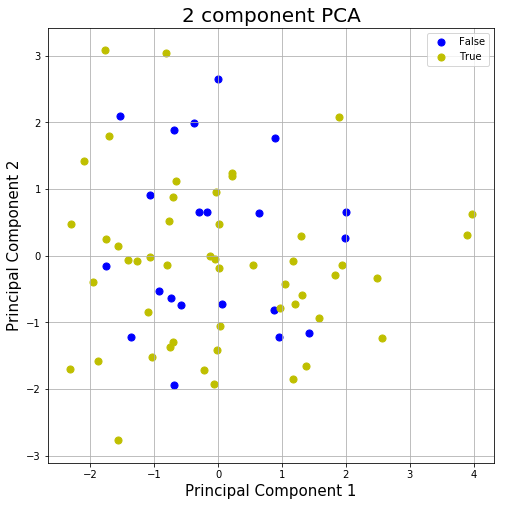

In [12]:
principalDf = pd.DataFrame(data = X_pca_train, columns = ['principal component 1', 'principal component 2'])
finalDf = pd.concat([principalDf, Y_train], axis = 1)

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)

targets = [False, True]
colors = ['b', 'y']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['fake'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [13]:
X_pca_test = pca_model.transform(X_std_test)

### Dimensional reduction with LDA

In [14]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
lda_model = LDA(n_components=2)
X_lda_train = lda_model.fit_transform(X_std_train, Y_train)

In [15]:
X_lda_test = lda_model.transform(X_std_test)

### Dimensional reduction with QDA

In [16]:
#from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
#qda_model = QDA()
#X_qda_train = qda_model.fit(X_std_train, Y_train)
#X_qda_train

In [17]:
#X_qda_test = lda_model.transform(X_std_test)

### Binary Classification with SVM

### From PCA Reduction

In [18]:
print('For rbf:', svc_param_selection(X_pca_train, Y_train, 2, 'rbf'))
print('For linear:', svc_param_selection(X_pca_train, Y_train, 2, 'linear'))
print('For poly:', svc_param_selection(X_pca_train, Y_train, 2, 'poly'))
print('For sigmoid:', svc_param_selection(X_pca_train, Y_train, 2, 'sigmoid'))

For rbf: {'C': 10, 'gamma': 0.01}
For linear: {'C': 1, 'gamma': 0.001}
For poly: {'C': 0.1, 'gamma': 1}
For sigmoid: {'C': 0.1, 'gamma': 1}


In [33]:
models = {}
models['rbf'] = svm.SVC(kernel='rbf', gamma=0.01, C= 10)
models['linear']  = svm.SVC(kernel='linear', gamma=0.001, C= 1)
models['poly']  = svm.SVC(kernel='poly', gamma=1, C= 0.1)
models['sigmoid'] = svm.SVC(kernel='sigmoid', gamma=1, C= 0.1)

In [34]:
scores = s.run_models(models, X_pca_train, Y_train, X_pca_test, Y_test)
for model in scores:
    print('For model', model)
    print('Training score: {}. Test score: {}'.format(scores[model]['train'],scores[model]['test']))

For model rbf
Training score: 0.7111111111111111. Test score: 0.6153846153846154
For model linear
Training score: 0.7111111111111111. Test score: 0.6153846153846154
For model poly
Training score: 0.6666666666666666. Test score: 0.5263157894736842
For model sigmoid
Training score: 0.6666666666666666. Test score: 0.5833333333333334


### From LDA reduction

In [21]:
print('For rbf:', svc_param_selection(X_lda_train, Y_train, 2, 'rbf'))
print('For linear:', svc_param_selection(X_lda_train, Y_train, 2, 'linear'))
print('For poly:', svc_param_selection(X_lda_train, Y_train, 2, 'poly'))
print('For sigmoid:', svc_param_selection(X_lda_train, Y_train, 2, 'sigmoid'))

For rbf: {'C': 1, 'gamma': 1}
For linear: {'C': 0.1, 'gamma': 0.001}
For poly: {'C': 0.01, 'gamma': 1}
For sigmoid: {'C': 1, 'gamma': 0.1}


In [35]:
models = {}
models['rbf'] = svm.SVC(kernel='rbf', gamma=1, C= 1)
models['linear']  = svm.SVC(kernel='linear', gamma=0.001, C= 0.1)
models['poly']  = svm.SVC(kernel='poly', gamma=1, C= 0.01)
models['sigmoid'] = svm.SVC(kernel='sigmoid', gamma=0.1, C= 1)

In [36]:
scores = s.run_models(models, X_lda_train, Y_train, X_lda_test, Y_test)
for model in scores:
    print('For model', model)
    print('Training score: {}. Test score: {}'.format(scores[model]['train'],scores[model]['test']))

For model rbf
Training score: 0.7444444444444445. Test score: 0.6
For model linear
Training score: 0.7222222222222222. Test score: 0.5384615384615384
For model poly
Training score: 0.6444444444444445. Test score: 0.5238095238095238
For model sigmoid
Training score: 0.7222222222222222. Test score: 0.5384615384615384


### Binary Classification with Random Forest

In [24]:
from src.fake_news_detector.core.classificators import helpers as h
from sklearn.ensemble import RandomForestClassifier

In [25]:
clf = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)
clf.fit(X_pca_train, Y_train)
Y_pred = clf.predict(X_pca_test)
scrore_train, score_test = h.print_evaluation(clf, X_pca_train, Y_train, Y_test, Y_pred, False)

print('Training score: {}. Test score: {}'.format(scrore_train,score_test))

Training score: 0.7555555555555555. Test score: 0.5625


In [26]:
clf = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)
clf.fit(X_lda_train, Y_train)
Y_pred = clf.predict(X_lda_test)
scrore_train, score_test = h.print_evaluation(clf, X_lda_train, Y_train, Y_test, Y_pred, False)

print('Training score: {}. Test score: {}'.format(scrore_train,score_test))

Training score: 0.7444444444444445. Test score: 0.6666666666666666
